In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('plots/paper.mplstyle')

import seaborn as sns

from scipy.optimize import curve_fit

#https://docs.scipy.org/doc/scipy/reference/odr.html

def second_order_pol(x, p1, p2, p3):
    return p1*x**2 + p2*x + p3

In [2]:
res = pd.read_csv("results/2022_05_all_runs.csv")
# exclude the lowest frequency bin
res.head()

,tstamp,nspots,hem,nflares,color
0,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00
1,2022_03_29_10_44_2022_03_29_09_43,1,bi-hem.,20-40,#E69F00
2,2022_03_30_20_42_2022_03_30_20_25,1,bi-hem.,17-28,#E69F00
3,2022_03_24_15_52_2022_03_24_15_18,1,bi-hem.,10-20,#E69F00
4,2022_03_30_21_00_2022_03_30_20_44,1,bi-hem.,8-15,#E69F00


In [40]:
ms = pd.read_csv("results/2022_05_all_mean_stds.csv")
ms.head()

,tstamp,nspots,hem,nflares,c,latitude,mean_of_wtd_means,mean_of_wtd_stds,std_of_wtd_means,std__of_wtd_stds
0,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,10,0.040497,0.081001,0.000835,0.003024
1,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,15,0.039797,0.077973,0.001158,0.003971
2,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,20,0.038758,0.073823,0.000902,0.003553
3,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,25,0.038176,0.071557,0.000793,0.003376
4,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,30,0.037400,0.068220,0.001189,0.004528


In [8]:
from scipy.odr import Model, RealData, ODR

In [30]:
def latfit(b0,x):
#     print(x, b0)
    mu, sig = x
    a,b,c,d,e = b0
    return (a * mu**2 + b * mu + c) * (d * np.exp(-mu * e) + 1)

In [43]:
mono= ms[ms.c == "#E69F00"]
mono.head()

,tstamp,nspots,hem,nflares,c,latitude,mean_of_wtd_means,mean_of_wtd_stds,std_of_wtd_means,std__of_wtd_stds
0,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,10,0.040497,0.081001,0.000835,0.003024
1,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,15,0.039797,0.077973,0.001158,0.003971
2,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,20,0.038758,0.073823,0.000902,0.003553
3,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,25,0.038176,0.071557,0.000793,0.003376
4,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,30,0.037400,0.068220,0.001189,0.004528


In [52]:
f = Model(latfit)
x = np.array([mono.mean_of_wtd_means.values,mono.mean_of_wtd_stds.values])
y = mono.latitude.values
sx = np.array([mono.std_of_wtd_means.values,mono.std__of_wtd_stds.values])
sy = np.full_like(y,2.)
mydata = RealData(x, y, sx=sx, sy=sy)

In [59]:
myodr = ODR(mydata, f, beta0=[1., 2.,1., 2.,1., ],maxit=2000)

In [60]:
myoutput = myodr.run()

In [64]:
myoutput.beta

array([ 3.69989440e+03, -1.14042786e+03,  8.19423865e+01,  1.08149050e-03,
       -9.98462944e+01])

In [65]:
myoutput.sd_beta

array([5.18612102e+02, 1.39578163e+02, 8.93028670e+00, 1.94601753e-03,
       2.21897712e+01])

In [67]:
pd.DataFrame(myoutput.cov_beta)

,0,1,2,3,4
0,4390.467563,-1151.994315,68.532190,-1.136869e-02,-127.500306
1,-1151.994315,318.024398,-19.819345,3.371837e-03,37.170782
2,68.532190,-19.819345,1.301836,-2.228995e-04,-2.393376
3,-0.011369,0.003372,-0.000223,6.181857e-08,0.000696
4,-127.500306,37.170782,-2.393376,6.962420e-04,8.037688


In [61]:
myoutput.pprint()

Beta: [ 3.69989440e+03 -1.14042786e+03  8.19423865e+01  1.08149050e-03
 -9.98462944e+01]
Beta Std Error: [5.18612102e+02 1.39578163e+02 8.93028670e+00 1.94601753e-03
 2.21897712e+01]
Beta Covariance: [[ 4.39046756e+03 -1.15199431e+03  6.85321897e+01 -1.13686907e-02
  -1.27500306e+02]
 [-1.15199431e+03  3.18024398e+02 -1.98193451e+01  3.37183683e-03
   3.71707818e+01]
 [ 6.85321897e+01 -1.98193451e+01  1.30183602e+00 -2.22899490e-04
  -2.39337607e+00]
 [-1.13686907e-02  3.37183683e-03 -2.22899490e-04  6.18185730e-08
   6.96241975e-04]
 [-1.27500306e+02  3.71707818e+01 -2.39337607e+00  6.96241975e-04
   8.03768773e+00]]
Residual Variance: 61.25965135008234
Inverse Condition #: 3.210777472806094e-07
Reason(s) for Halting:
  Iteration limit reached


# Fixed mean

Text(0, 0.5, 'mean WTD [rotation period]')

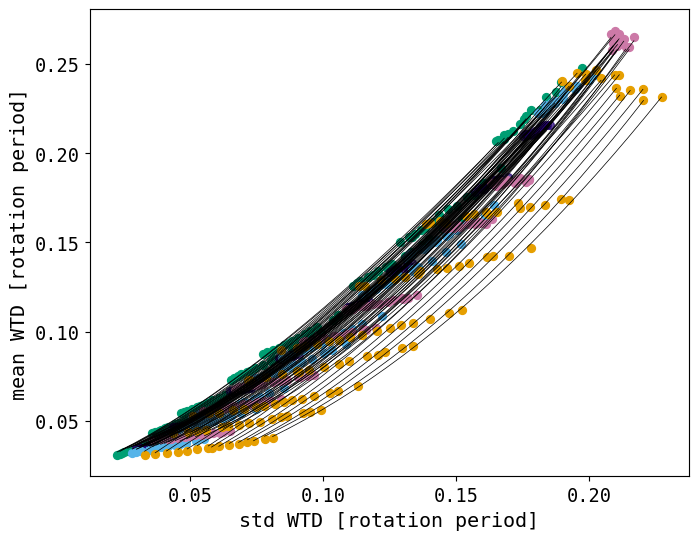

In [225]:
plt.figure(figsize=(7.5,6))
def powerlaw(x,a,b,c):
    return a*x**b +c

def neg_powerlaw(x,a,b,c):
    return (-a)*x**b +c

fits = {}
i=0
for c, g in ms.groupby("c"):
    fits[c] = {}
    for lat, h in g.groupby("latitude"):
#     g["stdomean"]= g.mean_of_wtd_stds
#     g = g.sort_values("stdomean",ascending=True)
        fits[c][lat] = {}
        minmean, maxmean = h.mean_of_wtd_stds.min(), h.mean_of_wtd_stds.max()
        plt.scatter(h.mean_of_wtd_stds, h.mean_of_wtd_means+i,c=c,label=lat,s=30)
        resul = curve_fit(powerlaw, h.mean_of_wtd_stds,h.mean_of_wtd_means)[0]
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        fits[c][lat]["minmean"] = minmean
        fits[c][lat]["maxmean"] = maxmean
        x = np.linspace(minmean, maxmean,25)
        plt.plot(x, powerlaw(x, *resul)+i,c="k",linewidth=0.5)
        i += 0.00
plt.xlabel("std WTD [rotation period]")
plt.ylabel("mean WTD [rotation period]")
# plt.legend()
# plt.xlim(0.04,0.2)
# plt.ylim(0.03,0.22)
# plt.xscale("log")
# plt.yscale("log")

In [226]:
# extrapolate the equi-latitude lines to allow us to switch axes

fits = {}
for c, mono in ms.groupby("c"):
    fits[c] = {}
    for lat, h in mono.groupby("latitude"):
        fits[c][lat] = {}
        resul = curve_fit(powerlaw,h.mean_of_wtd_stds,h.mean_of_wtd_means)[0]
        minmean, maxmean = h.mean_of_wtd_stds.min(), h.mean_of_wtd_stds.max()
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        fits[c][lat]["minmean"] = minmean
        fits[c][lat]["maxmean"] = maxmean
        
reform = {(outerKey, innerKey): values for outerKey, innerDict in fits.items() for innerKey, values in innerDict.items()}        
df = pd.DataFrame(reform).T


In [227]:
df = df.reset_index().set_index("level_1").rename(index=str, columns={"level_0":"color"})
df

,color,a,b,c,minmean,maxmean
level_1,,,,,,
10,#009E73,3.254288,1.666705,0.027787,0.040491,0.197193
15,#009E73,3.482520,1.690287,0.027981,0.038278,0.189406
20,#009E73,2.975376,1.594352,0.025230,0.036561,0.187723
25,#009E73,3.321472,1.653370,0.027192,0.034958,0.183650
30,#009E73,2.669783,1.521181,0.023197,0.032958,0.181503
...,...,...,...,...,...,...
60,#E69F00,2.512076,1.465915,0.004267,0.048899,0.202567
65,#E69F00,2.333915,1.406952,0.003963,0.045448,0.198683
70,#E69F00,2.148274,1.346945,0.004051,0.041116,0.192499


In [243]:
# switch axes
dd = {}
for color, g in df.groupby("color"):
    dd[color] = {}
    for mean in np.linspace(0.02,0.25, 30):
        dd[color][mean] = {}
        for i, row in g.iterrows():
            if (mean > (row.minmean-0.005)) & (mean < row.maxmean+0.005):
                std = powerlaw(mean, row.a,row.b,row.c)
                dd[color][mean][i]= std

reform = {(outerKey, innerKey): values for outerKey, innerDict in dd.items() for innerKey, values in innerDict.items()}        
ddd = pd.DataFrame(reform).T.reset_index().rename(index=str, columns={"level_1":"mean","level_0":"color"})
ddd = ddd.set_index("mean")

ddd

,color,70,75,80,35,40,45,50,55,60,65,10,15,20,25,30
mean,,,,,,,,,,,,,,,,
0.020000,#009E73,0.031073,0.030378,0.030884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.027931,#009E73,0.036521,0.036360,0.036764,0.035557,0.035346,0.035562,0.035475,0.035647,0.035732,0.036330,NaN,NaN,NaN,NaN,NaN
0.035862,#009E73,0.042690,0.042984,0.043315,0.040778,0.040777,0.041144,0.041312,0.041537,0.041828,0.042381,0.040476,0.040536,0.039992,0.040732,0.040094
0.043793,#009E73,0.049484,0.050151,0.050438,0.046690,0.046889,0.047389,0.047782,0.048064,0.048533,0.049061,0.045491,0.045580,0.045529,0.046032,0.046095
0.051724,#009E73,0.056835,0.057796,0.058067,0.053235,0.053621,0.054233,0.054818,0.055165,0.055779,0.056304,0.051151,0.051298,0.051698,0.052000,0.052693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.218276,#E69F00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215148,0.225365,0.232125,0.240484,NaN
0.226207,#E69F00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229555,NaN,NaN,NaN,NaN
0.234138,#E69F00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
ddd = ddd.reindex(sorted(ddd.columns), axis=1)
ddd

,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,color
mean,,,,,,,,,,,,,,,,
0.020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031073,0.030378,0.030884,#009E73
0.027931,NaN,NaN,NaN,NaN,NaN,0.035557,0.035346,0.035562,0.035475,0.035647,0.035732,0.036330,0.036521,0.036360,0.036764,#009E73
0.035862,0.040476,0.040536,0.039992,0.040732,0.040094,0.040778,0.040777,0.041144,0.041312,0.041537,0.041828,0.042381,0.042690,0.042984,0.043315,#009E73
0.043793,0.045491,0.045580,0.045529,0.046032,0.046095,0.046690,0.046889,0.047389,0.047782,0.048064,0.048533,0.049061,0.049484,0.050151,0.050438,#009E73
0.051724,0.051151,0.051298,0.051698,0.052000,0.052693,0.053235,0.053621,0.054233,0.054818,0.055165,0.055779,0.056304,0.056835,0.057796,0.058067,#009E73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.218276,0.215148,0.225365,0.232125,0.240484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#E69F00
0.226207,0.229555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#E69F00
0.234138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#E69F00


(0.0, 100.0)

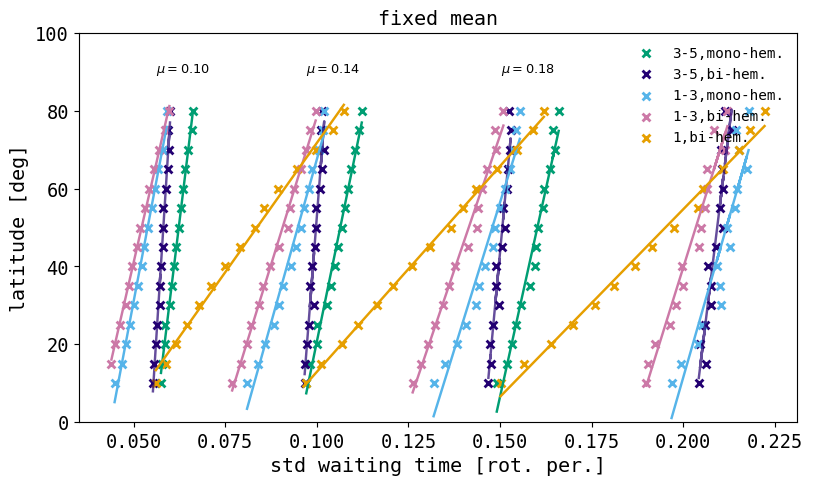

In [245]:
def third_order_pol(x, a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d
def first_order_pol(x, a,b):
    return a*x - b
def fourth_order_pol(x, a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x +e
def sinfunc(x, a,b,c):
    return np.cos(a*x - b) + c
def neg_expfunc(x, a,b,c):
    return a + (-b) * np.exp(x*(-c))
def expfunc(x, a,b,c):
    return a + b * np.exp(x*c)

fig, ax = plt.subplots(figsize=(9,5))
latstd = {}
for c, g in ddd.groupby("color"):
    i=0
    latstd[c] = {}
    for mean, row in g.iterrows():
        
        x = row.values[:-1].astype(float)
        y = row.index.values[:-1].astype(float)
        y = y[~np.isnan(x)]
        x = x[~np.isnan(x)]
#         print(y.shape,x.shape)
        if y.shape[0]>10:
            res = curve_fit(first_order_pol,x,y)[0]
            latstd[c][mean] = dict(zip(["m","c"],res))#"p3","p2",
            if i%5==0:

                ax.plot(x.astype(float), first_order_pol(x,*res),c=c, linewidth=1.7)

                if i == 10:
                    label = f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}"
                    ax.scatter(x,y, c=c, s=30,marker="x",alpha=1,
                             label=label,)
                    if c=="#E69F00":
                        plt.text(x=x[0],y=90,s=fr"$\mu={mean:.2f}$",fontsize=9)
                else:
                    ax.scatter(x,y,  c=c, s=30,marker="x",alpha=1,)
                    if c=="#E69F00":
                        plt.text(x=x[0],y=90,s=fr"$\mu={mean:.2f}$",fontsize=9)
        i += 1
plt.legend(fontsize=10,frameon=False)
plt.xlabel("std waiting time [rot. per.]")
plt.ylabel("latitude [deg]")
plt.title("fixed mean")
plt.ylim(0,100)
# plt.grid();

In [246]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in latstd.items() for innerKey, values in innerDict.items()}        
latstdd = pd.DataFrame(reform).T

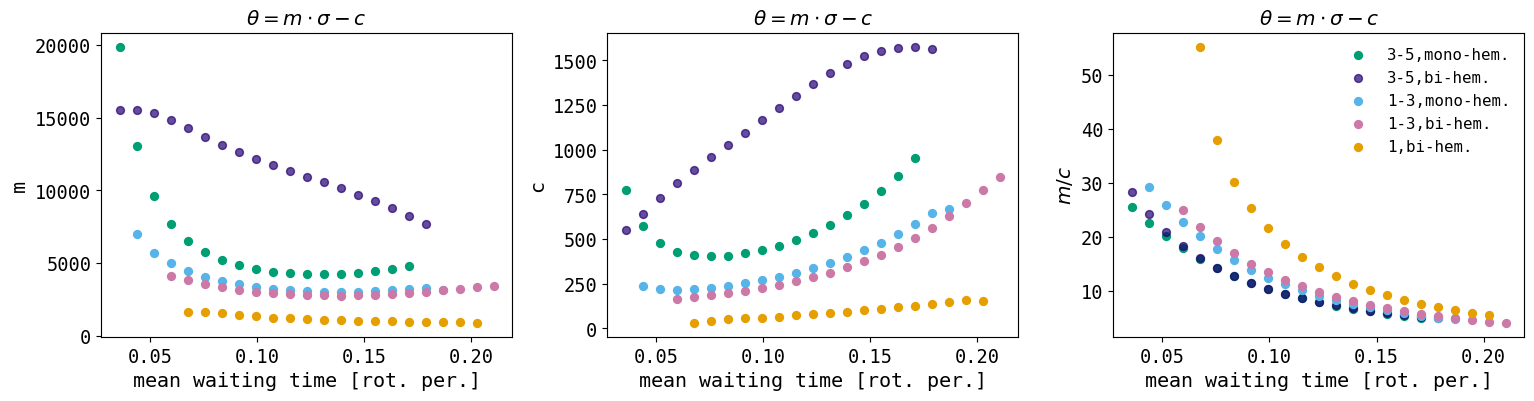

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,4))
for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)

    for axis, col in list(zip(ax[:-1],g.columns.values)):
        axis.scatter(g.index.values, g[col].values,c=c,s=30,
                     label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

        axis.set_ylabel(col)
        axis.set_xlabel("mean waiting time [rot. per.]")
        axis.set_title(fr"$\theta = m \cdot \sigma - c$")
#         axis.set_yscale("log")
#         axis.set_xscale("log")

for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)


    ax[-1].scatter(g.index.values, (g["m"]/g["c"]).values,c=c,s=30,
                 label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

    ax[-1].set_ylabel(r"$m/c$")
    ax[-1].set_xlabel("mean waiting time [rot. per.]")
#     ax[-1].set_yscale("log")
    ax[-1].set_title(fr"$\theta = m \cdot \sigma - c$")

plt.tight_layout()
ax[-1].legend(frameon=False,fontsize=11)
# ax[1].set_ylim(-170,-25)
# ax[0].set_ylim(0,2000)

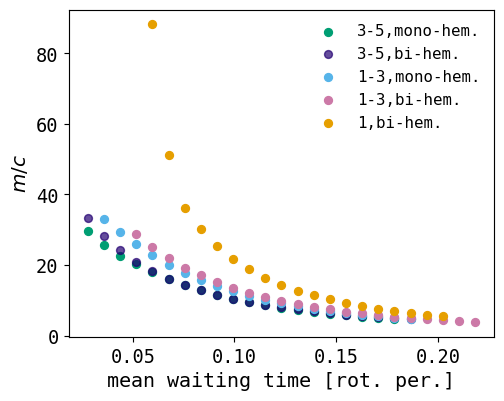

In [239]:
fig, axis = plt.subplots(nrows=1, ncols=1,figsize=(5,4))
for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)


    axis.scatter(g.index.values, (g["m"]/g["c"]).values,c=c,s=30,
                 label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

    axis.set_ylabel(r"$m/c$")
    axis.set_xlabel("mean waiting time [rot. per.]")
#     axis.set_title(fr"$\theta = m \cdot \sigma - c$")
#     axis.set_yscale("log")
#         axis.set_xscale("log")
plt.tight_layout()
axis.legend(frameon=False,fontsize=11)

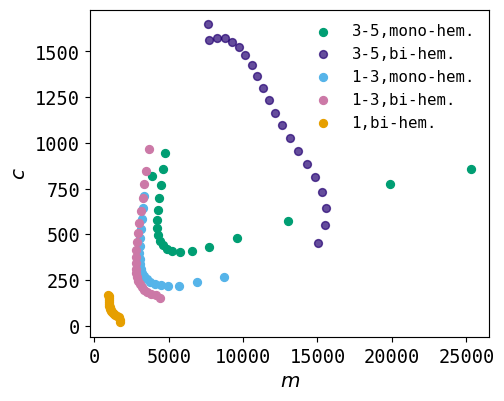

In [240]:
fig, axis = plt.subplots(nrows=1, ncols=1,figsize=(5,4))
for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)


    axis.scatter(g["m"].values, g["c"].values,c=c,s=30,
                 label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

    axis.set_xlabel(r"$m$")
    axis.set_ylabel(r"$c$")
#     axis.set_title(fr"$\theta = m \cdot \sigma - c$")
#     axis.set_yscale("log")
#         axis.set_xscale("log")
plt.tight_layout()
axis.legend(frameon=False,fontsize=11)

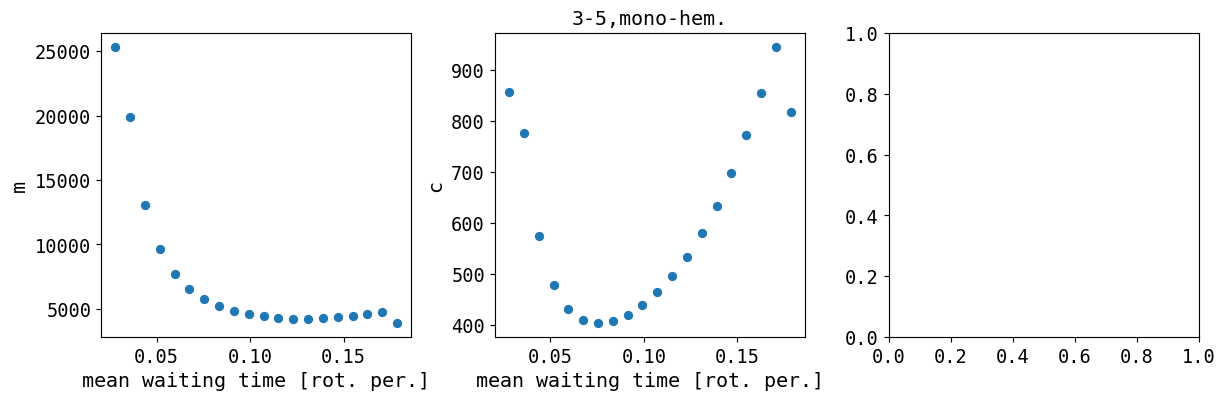

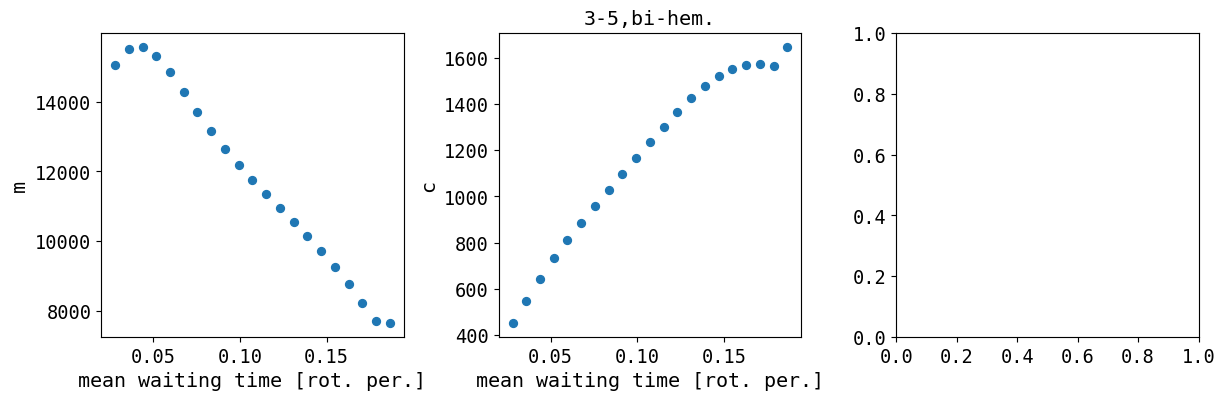

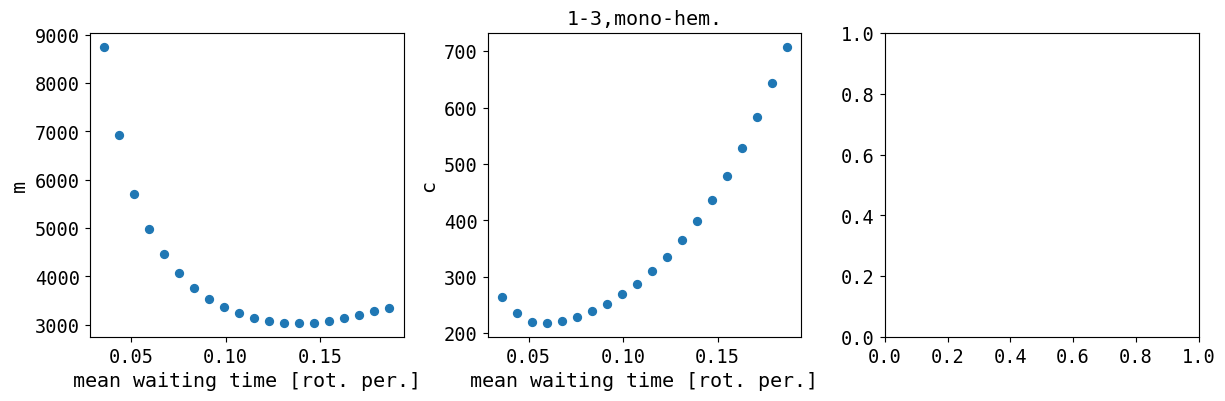

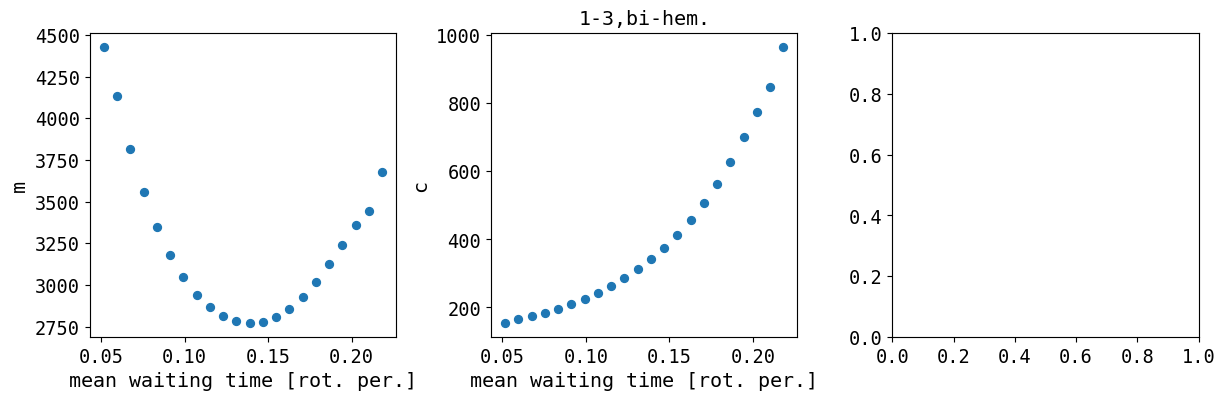

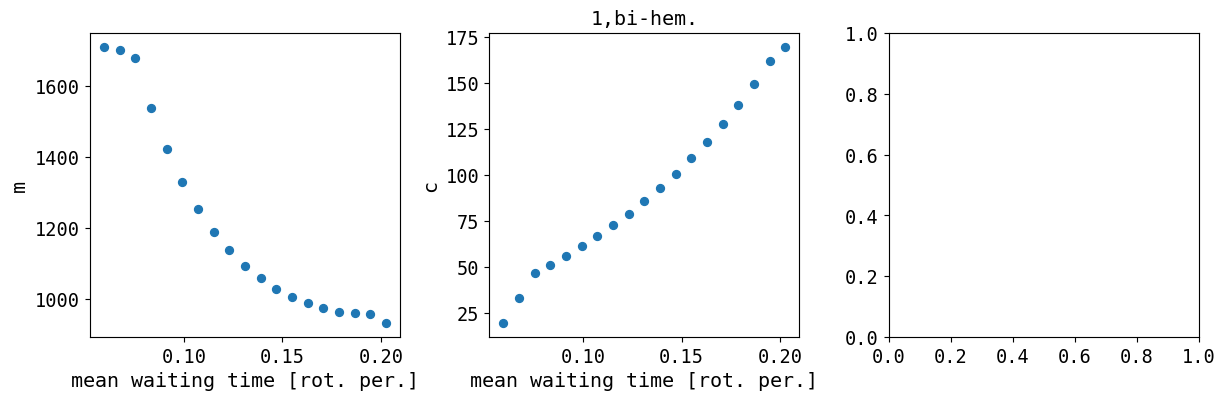

In [241]:
for c, g in latstdd.groupby(level=0):
    g = g.reset_index(level=0).drop("level_0",axis=1)
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,4))

    for axis, col in list(zip(ax,g.columns.values)):
        axis.scatter(g.index.values, g[col].values,s=30)
#         axis.set_xlim(0.06,0.2)
        axis.set_ylabel(col)
        axis.set_xlabel("mean waiting time [rot. per.]")
    ax[1].set_title(f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")
    plt.tight_layout()

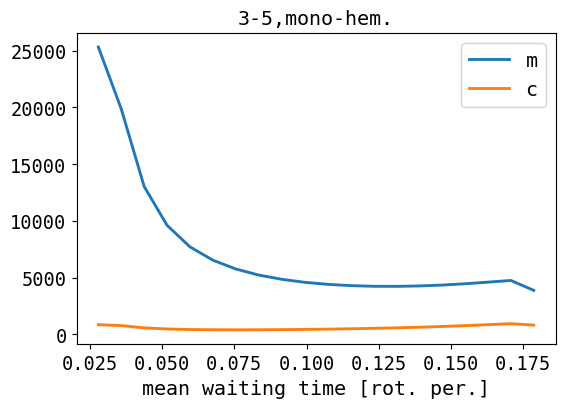

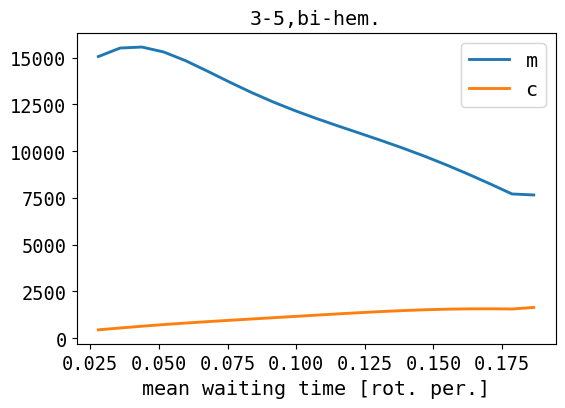

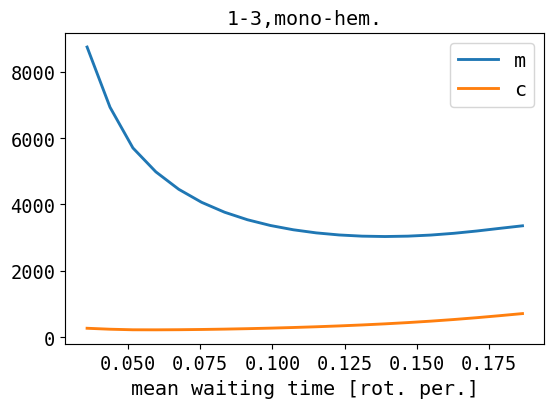

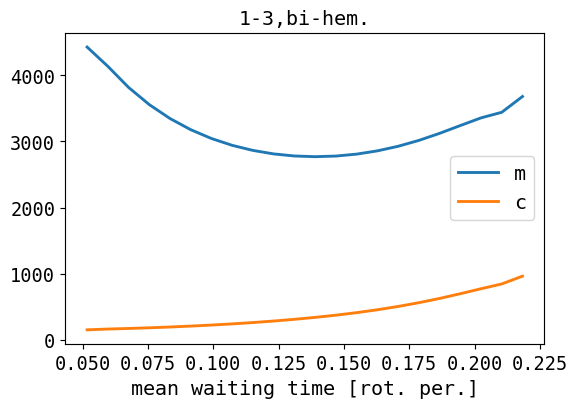

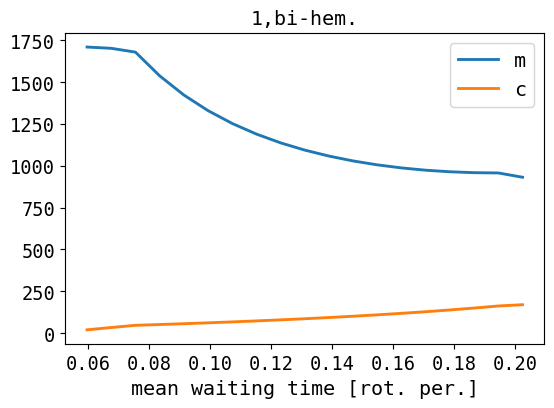

In [242]:

reform = {(outerKey, innerKey): values for outerKey, innerDict in latstd.items() for innerKey, values in innerDict.items()}        
latstdd = pd.DataFrame(reform).T

for c, g in latstdd.groupby(level=0):
    g = g.reset_index(level=0).drop("level_0",axis=1)
    g.plot()
    plt.xlabel("mean waiting time [rot. per.]")
    plt.title(f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")


# Fixed STD

Text(0, 0.5, 'std WTD [rotation period]')

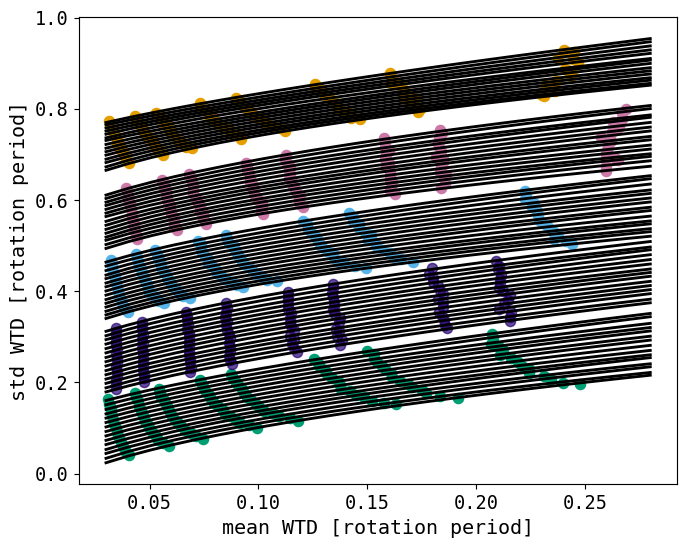

In [105]:
plt.figure(figsize=(7.5,6))
def powerlaw(x,a,b,c):
    return a*x**b +c

fits = {}
i=0
for c, g in ms.groupby("c"):
    fits[c] = {}
    for lat, h in g.groupby("latitude"):
#     g["stdomean"]= g.mean_of_wtd_stds
#     g = g.sort_values("stdomean",ascending=True)
        fits[c][lat] = {}
        plt.scatter(h.mean_of_wtd_means,h.mean_of_wtd_stds+i,c=c,label=lat,s=50)
        resul = curve_fit(powerlaw, h.mean_of_wtd_means, h.mean_of_wtd_stds)[0]
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        x = np.linspace(0.03,0.28,25)
        plt.plot(x, powerlaw(x, *resul)+i,c="k")
        i += 0.01
plt.xlabel("mean WTD [rotation period]")
plt.ylabel("std WTD [rotation period]")
# plt.legend()
# plt.xlim(0.04,0.2)
# plt.ylim(0.03,0.22)
# plt.xscale("log")
# plt.yscale("log")

In [106]:
# extrapolate the equi-latitude lines to allow us to switch axes

fits = {}
for c, mono in ms.groupby("c"):
    fits[c] = {}
    for lat, h in mono.groupby("latitude"):
        fits[c][lat] = {}
        resul = curve_fit(powerlaw, h.mean_of_wtd_means,h.mean_of_wtd_stds)[0]
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        
reform = {(outerKey, innerKey): values for outerKey, innerDict in fits.items() for innerKey, values in innerDict.items()}        
df = pd.DataFrame(reform).T
df = df.reset_index().set_index("level_1").rename(index=str, columns={"level_0":"color"})

In [112]:
# switch axes
dd = {}
for color, g in df.groupby("color"):
    dd[color] = {}
    for std in np.linspace(0.05,0.2, 20):
        dd[color][std] = {}
        for i, row in g.iterrows():
            mean = powerlaw(std, row.a,row.b,row.c)
            dd[color][std][i]= mean

reform = {(outerKey, innerKey): values for outerKey, innerDict in dd.items() for innerKey, values in innerDict.items()}        
ddd = pd.DataFrame(reform).T.reset_index().rename(index=str, columns={"level_1":"std","level_0":"color"})
ddd = ddd.set_index("std")



(0.0, 100.0)

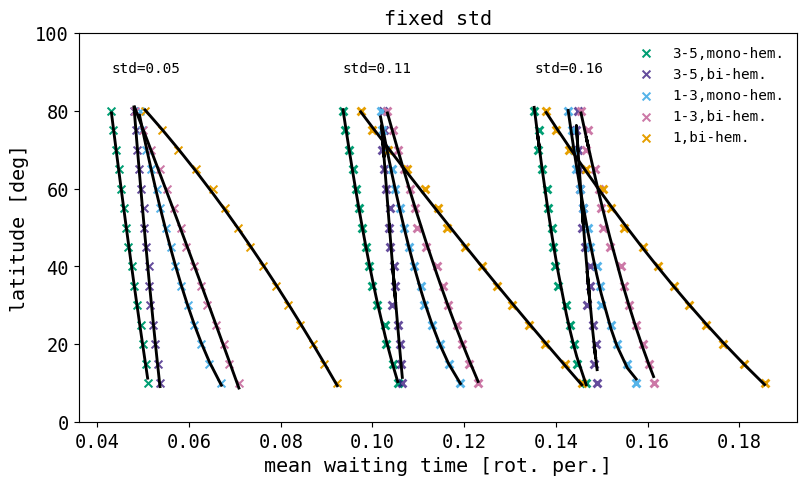

In [114]:
fig, ax = plt.subplots(figsize=(9,5))
latmean = {}
for c, g in ddd.groupby("color"):
    i=0
    latmean[c] = {}
    for std, row in g.iterrows():
        latmean[c][std] = dict(zip(["p2","p1","p0"],res))
        x = row.values[1:]
        y = row.index.values[1:].astype(float)

        res = curve_fit(second_order_pol,x,y)[0]
        
        if i%7==0:
            
#             print(x,second_order_pol(x,*res))
            ax.plot(x.astype(float), second_order_pol(x,*res),c="k")
#             ax.scatter(x.astype(float),y.astype(float),c=c)
            if std == 0.05:
                ax.scatter(x,y, c=c, s=30,marker="x",
                         label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}", linewidth=1.4)
                if c=="#009E73":
                    plt.text(x=x[-1],y=90,s=f"std={std:.2f}")
            else:
                ax.scatter(x,y,  c=c, s=30,marker="x")
                if c=="#009E73":
                    plt.text(x=x[-1],y=90,s=f"std={std:.2f}")
        i += 1
plt.legend(fontsize=10,frameon=False)
plt.xlabel("mean waiting time [rot. per.]")
plt.ylabel("latitude [deg]")
plt.title("fixed std")
plt.ylim(0,100)
# plt.grid();

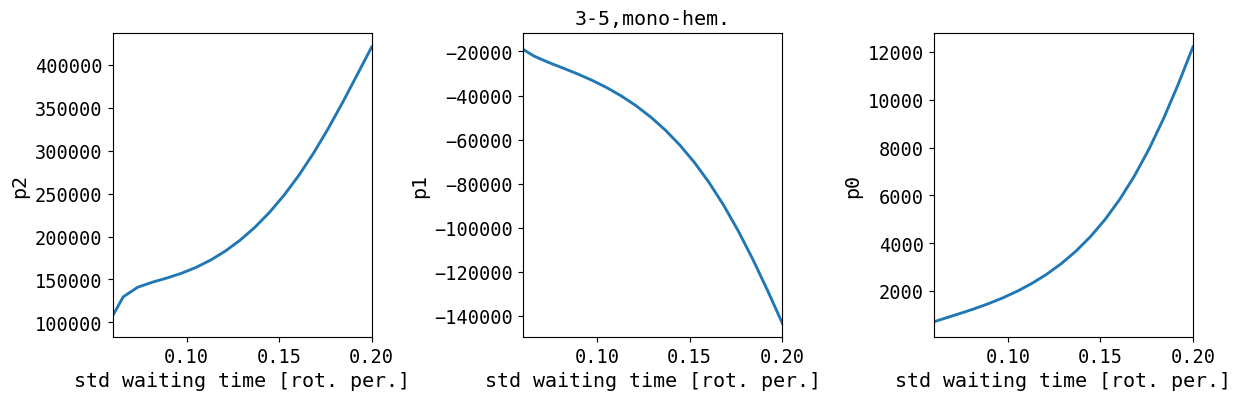

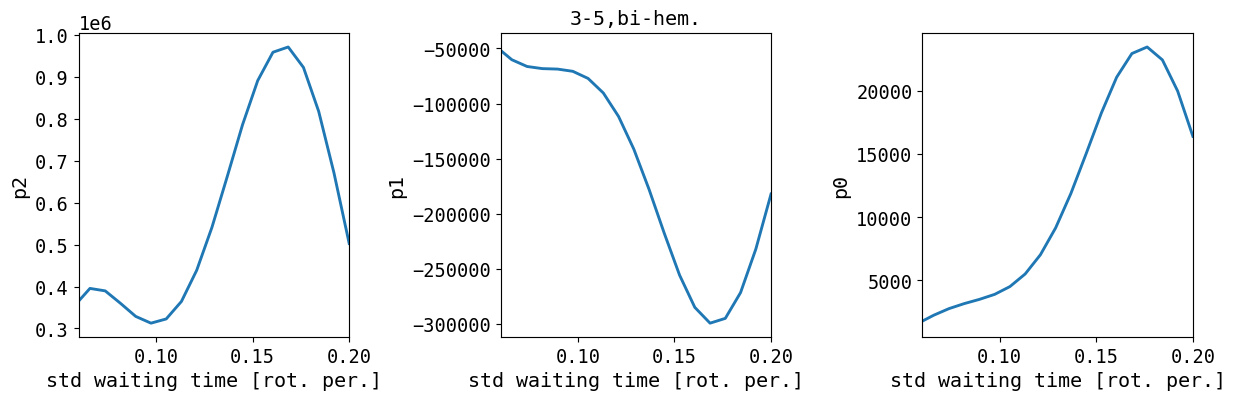

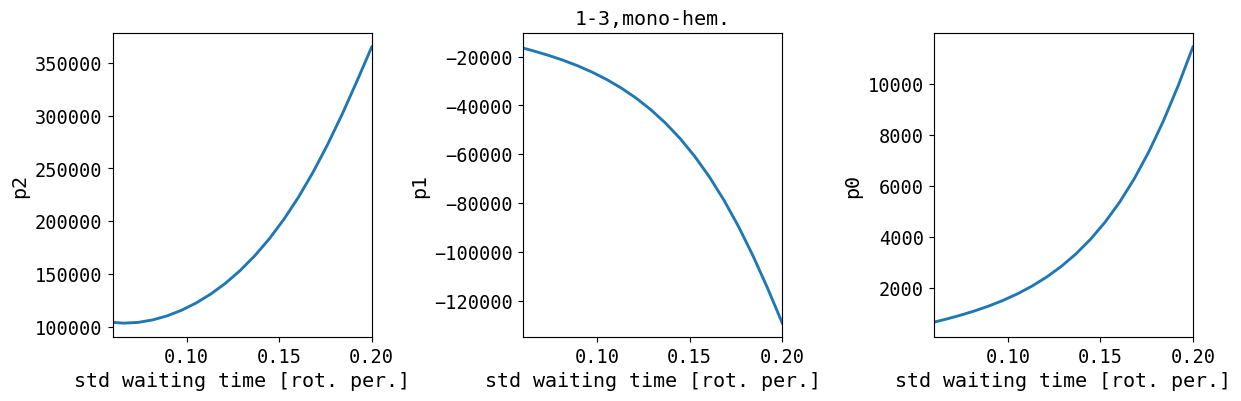

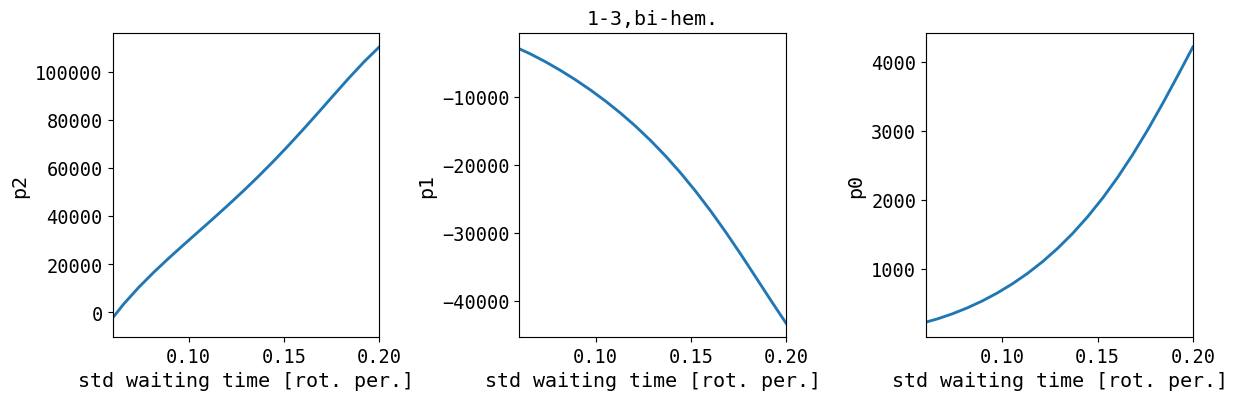

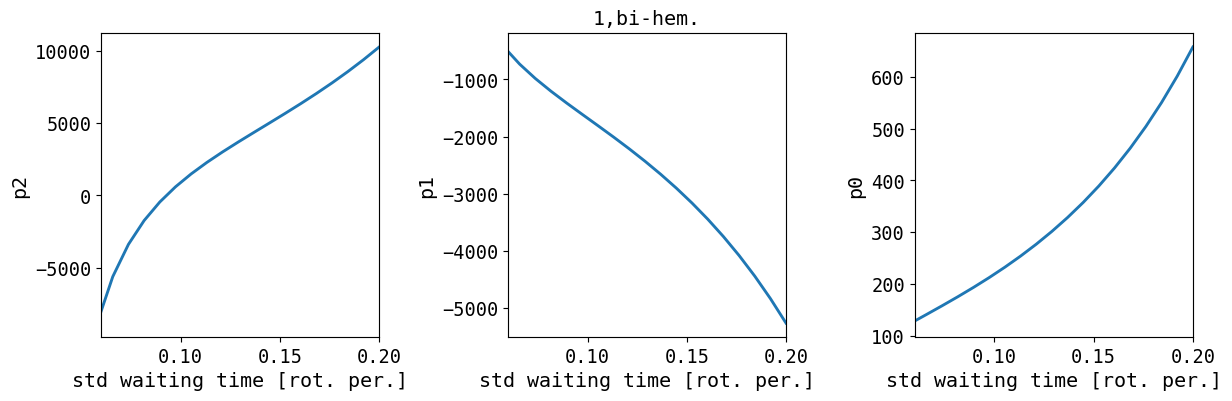

In [126]:

reform = {(outerKey, innerKey): values for outerKey, innerDict in latmean.items() for innerKey, values in innerDict.items()}        
latmeand = pd.DataFrame(reform).T

for c, g in latmeand.groupby(level=0):
    g = g.reset_index(level=0).drop("level_0",axis=1)
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,4))
    g = g.loc[g.index>.05]
    for axis, col in list(zip(ax,g.columns.values)):
        axis.plot(g.index.values, g[col].values)
        axis.set_xlim(0.06,0.2)
        axis.set_ylabel(col)
        axis.set_xlabel("std waiting time [rot. per.]")
    ax[1].set_title(f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")
    plt.tight_layout()

In [116]:
latmeand

p2            p1           p0
#009E73 0.050000   11187.763431  -5733.411919   719.972275
        0.057895   99046.912691 -17960.113222   669.289076
        0.065789  129827.863692 -22057.656025   868.306633
        0.073684  141039.378099 -24957.174952  1060.286596
        0.081579  146866.847561 -27551.175359  1260.862738
...                         ...           ...          ...
#E69F00 0.168421    7040.775479  -3746.567078   462.329052
        0.176316    7774.984261  -4077.375839   504.281460
        0.184211    8549.400378  -4437.844650   550.481719
        0.192105    9371.457628  -4831.462565   601.442713
        0.200000   10248.487081  -5261.980892   657.731647

[100 rows x 3 columns]